In [1]:
from random import * # random numbers
import os, subprocess # to check and create directories 
import math # python math
import numpy as np # numerical python
import scipy # scientific python
from scipy import optimize # for numerical solution of equations
from matplotlib import pyplot as plt # plotting
import matplotlib.gridspec as gridspec # more plotting 
from prettytable import PrettyTable # pretty printing of tables
from tqdm import tqdm # display progress
from optparse import OptionParser # command line parameters
from scipy.integrate import quad # for numerical integrals
from matplotlib.ticker import MultipleLocator
from alphaS import * # for the alphaS calculation

################################################
print('\nPyresias: a toy parton shower\n')
print('Jupyter lab step-by-step tutorial')
# a simple toy q -> q+g parton shower 
#################################################


Pyresias: a toy parton shower

Jupyter lab step-by-step tutorial


At this point, we have loaded all the necessary Python libraries and printed the introduction. 

The next step is to setup the strong coupling constant, $\alpha_S$. This is done via the ```alphaS``` module, and it requires, $m_Z$ and $\alpha_S(m_Z)$, i.e. the value of $\alpha_S$ at the Z boson mass, $m_Z$.

In [2]:
# initialize alphaS: pass the value of alphaS at mz, and mz
aS = alphaS(0.118, 91.1876)

Let's now define some switches that will allow us to vary the evolution starting and cutoff scales, as well as whether to print debugging information.

```Qc``` and ```Q``` are the cutoff and "hard" scales, respectively. 

```Nevolve``` represents the number of "evolutions" to perform in this simple example. Note that kinematics will not be reconstructed in this warmup exercise.

In [29]:
#############
# SWITCHES: #
#############

# switch to print information or not:
debug = False
# switch to plot stuff or not:
plot = True

# RUN OPTIONS
# the number of branches to evolve:
Nevolve = 1000000
# the cutoff scale, e.g. 1 GeV. 
Qc = 1.
# the hard scale, e.g. 1000 GeV
Q = 1000.


The next step is to define the choice for the scale treatment. A fixed scale may be preferred in certain cases, e.g. to compare the splitting function to the distribution of the momentum fraction $z$ coming out of the simulation.

In [5]:
# fixed scale if the alphaS is fixed:
scaleoption = "fixed" # "pt" for the default scale, "fixed" for a fixed scale, given by fixedScale:
fixedScale = Q/2. # if the choice above is "fixed"

if scaleoption == "fixed":
    print('WARNING: alphaS is fixed during the evolution to scale=', Q/2)
    print('Set scaleoption = "pt" if you wish to capture some higher-order corrections')

Set scaleoption = "pt" if you wish to capture some higher-order corrections


Let's now define:

- the splitting function, $P(z) = C_F \frac{1+z^2}{1-z}$, given by ```Pqq(z)```,
- the overestimate of the splitting function $\hat{P} = C_F\frac{2}{1-z}$, given by ```Pqq_over(z)```,
- a function that returns the scale of $\alpha_S$, according to the global variable ```scaleoption```, ```scale_of_alphaS```,
- the function that returns $\alpha_S$, accessed through ```LHAPDF```, ```alphaS```,
- the function $t \times \hat{\Gamma}(z) = \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$, given by ```tGamma```.
- the inverse of the function $t \times \hat{\Gamma}(z)$, given by ```inversetGamma```,
- the overestimates of the limits of integration $\hat{z}_-$ and $\hat{z}_+$, given by ```zm_over``` and ```zp_over```,
- and the function that gives the overestimate of $\alpha_S$, ```get_alphaS_over```. 

In [6]:
# the q -> q + g splitting function
def Pqq(z): return CF * (1. + z**2)/(1.-z)
    
# the q -> q + g splitting function *overestimate* 
def Pqq_over(z): return 2.*CF/(1.-z)

# the scale choice of alphaS 
def scale_of_alphaS(t, z):
    if scaleoption == "pt":
        return z * (1-z) * math.sqrt(t)
    elif scaleoption == "fixed":
        return fixedScale

# return the true alphaS using the PDF alphaS over 2 pi
def alphaS(t, z, Qcut, aSover):
    scale = scale_of_alphaS(t, z)
    if scale < Qc:
        return aS.alphasQ(Qcut)/2./math.pi
    return aS.alphasQ(scale)/2./math.pi

# the analytical integral of t * Gamma over z 
def tGamma(z, aSover):
    return -2.*aSover*CF*np.log1p(-z) 

# the inverse of the function t*Gamma, given the overestimate for alphaS:
def inversetGamma(r, aSover):
    return 1. - math.exp(- 0.5*r/CF/aSover)

# the overestimated upper and lower limit for the z integral:
def zp_over(t, Qcut): return 1.-math.sqrt(Qcut**2/t)
def zm_over(t, Qcut): return math.sqrt(Qcut**2/t)

# set the overestimate of alphaS once and for all
def get_alphaS_over(Q, Qcut):
    if scaleoption == "pt":
        minscale = Qcut # the minimum scale^2 available to the PDF
        scale = minscale
    elif scaleoption == "fixed":
        scale = fixedScale
    alphaS_over = aS.alphasQ(scale)/2./math.pi
    if debug: print('alpha_S overestimate set to', alphaS_over, 'for scale=', scale, 'GeV')
    return alphaS_over

# get the momentum fraction candidate for the emission
def Get_zEmission(t, Qcut, R, aSover): return inversetGamma( tGamma(zm_over(t, Qcut), aSover) + R * ( tGamma(zp_over(t, Qcut), aSover) - tGamma(zm_over(t, Qcut), aSover)), aSover)

# calculate the transverse momentum of the emission
def Get_pTsq(t, z): return z**2 * (1-z)**2 * t

# calculate the virtual mass-squared of the emitting particle
def Get_mvirtsq(t,z): return z*(1-z) * t

Given the above, the treatment now proceeds as follows:

The overstimate of the Sudakov form factor is given by:

$\hat{\Delta}(t, t_\mathrm{max}) = \exp\left\{ - \int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') \right\}$,

with:

$\hat{\Gamma} (t') = \frac{1}{t'}   \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$.

We are working with the overestimated functions, and this allows us to analytically solve:

$\hat{\Delta}(t, t_\mathrm{max}) = R$, 

where $R$ is a random number in $[0,1]$. 

Therefore, we are seeking the solution of:

$\exp\left\{ - \int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') \right\} = R$,

or:

$\int^{t_\mathrm{max}}_{t} \mathrm{d}t' \hat{\Gamma} (t') = \ln\left(\frac{1}{R}\right)$.

We now define a function $\rho({\hat{z}_+},{\hat{z}_-}) = \int_{\hat{z}_-}^{\hat{z}^+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) = t'\hat{\Gamma} (t') $, to obtain:

$\int^{t_\mathrm{max}}_{t} \frac{\mathrm{d}t'}{t'} \rho = \ln\left(\frac{1}{R}\right)$, 

or:

$\int^{t_\mathrm{max}}_{t} \mathrm{d}\ln t' \rho = \ln\left(\frac{1}{R}\right)$.

If the limit overestimates in $\rho({\hat{z}_+},{\hat{z}_-})$ do not depend on $t'$, then: 

$\left. \rho \ln t \right|_t^{t_\mathrm{max}} = \ln\left(\frac{1}{R}\right) \Rightarrow \rho \ln \frac{t_\mathrm{max}}{t}  = \ln\left(\frac{1}{R}\right) $, 

which yields after exponentiation:

$t =  t_\mathrm{max} R^{1/\rho}$.

In the numerical evaluation of $t$, we instead focus on:

$\ln \frac{t}{t_\mathrm{max}} = \frac{1}{\rho} \ln R$,

and construct the function:

$E(t) = \ln \frac{t}{t_\mathrm{max}} - \frac{1}{\rho} \ln R$,

where now, explicitly, $\rho({\hat{z}_+},{\hat{z}_-}) = \int_{\hat{z}_-}^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) = \int^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z) - \int^{\hat{z}_-} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$.

The function ```EmissionScaleFunc``` in the code that follows corresponds to $E(t)$ and the $\rho$ function is calculated via: ```r = tGamma(zp_over(t, Qc), aSover) - tGamma(zm_over(t, Qc), aSover)```. 

The "next" value of $t$ is then calculated by solving $E(t)=0$ in the function ```Get_tEmission```. This is done numerically via ```scipy.optimize.ridder```. 

The ```Get_tEmission``` function actually finds the value of $\ln(t/t_\mathrm{max})$ for which the solution is obtained, and therefore needs to be exponentiated and multiplied by $t_\mathrm{max}$ (represented by ```Q**2```) to get the value of $t$. 

In [7]:
# the function E(ln(t/Q**2)) = ln(t/Q**2) - (1/r) ln(R) for the numerical solution for the evolution scale, given random number R
def EmissionScaleFunc(logt_over_Qsq, Q, Qcut, R, aSover):
    # calculate t:
    t = Q**2 * math.exp( logt_over_Qsq )
    # get r:
    r = tGamma(zp_over(t, Qcut), aSover) - tGamma(zm_over(t, Qcut), aSover)
    # calculate E(ln(t/Q**2)), the equation to solve
    return logt_over_Qsq - (1./r) * math.log(R)

# a function that calculates (numerically) the emission scale given the initial scale Q, cutoff Qc and random number R
def Get_tEmission(Q, Qcut, R, tfac, aSover):
    tolerance = 1E-3 # the tolerance for the solution
    popt = [Q, Qcut, R, aSover] # options to pass to the function for the solver
    EmissionFunc_arg = lambda tEm : EmissionScaleFunc(tEm, *popt) # the function in a form appropriate for the solver
    # calculate the solution using "Ridder's" method
    sol, results = scipy.optimize.ridder(EmissionFunc_arg, math.log(tfac*Qcut**2/Q**2), 0., xtol=tolerance, full_output=True, maxiter=1000)
    # get the actual evolution variable from the solution
    tEm_sol = Q**2 * math.exp( sol )
    # if a solution has not been found, terminate the evolution        
    if abs(EmissionFunc_arg(sol)) > tolerance:
            return Q**2, [], False
    # otherwise return the emission scale and continue
    return tEm_sol, results, True

To get the $z$ variable, we need to solve:

$ \rho (z,{\hat{z}_-}) = R' \rho({\hat{z}_+},{\hat{z}_-})$,

where $R'$ is another random number in $[0,1]$. 

Recalling that: 

$t' \hat{\Gamma} (t') = \int_{\hat{z}_-}^{\hat{z}_+} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$, 

we now define

$\tilde{\rho}(z) = \int^{z} \mathrm{d} z \frac{\hat{\alpha_S}}{2\pi} \hat{P}(z)$, we can write the equation for $z$ as:

$\tilde{\rho}(z) - \tilde{\rho}({\hat{z}_-}) = R' \left[ \tilde{\rho}({\hat{z}_+}) - \tilde{\rho}({\hat{z}_-}) \right]$,

and we obtain $z$ by solving:

$ z = \tilde{\rho}^{-1} \left\{ \tilde{\rho}({\hat{z}_-}) + R' \left[\tilde{\rho}({\hat{z}_+}) - \tilde{\rho}({\hat{z}_-}) \right] \right\}$,

where $\tilde{\rho}^{-1}$ is the inverse of $\tilde{\rho}$, which is given by the ```inversetGamma``` function in our code. 

The following function ```Generate_Emission``` solves for the next $t$ and $z$ using the overestimates, and then implements the vetoing by constructing a probability with the full splitting function and value of $\alpha_S$. 

In [8]:
# function that generates emissions:
def Generate_Emission(Q, Qcut, tfac, aSover):
    generated = True
    # generate random numbers
    R1 = random()
    R2 = random()
    R3 = random()
    R4 = random()
    # solve for the (candidate) emission scale:
    tEm, results, continueEvolution = Get_tEmission(Q, Qcut, R1, tfac, aSover)
    # if no solution is found then end branch
    if continueEvolution == False:
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
        return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution
    if debug: print('\tcandidate emission scale, sqrt(tEm)=', math.sqrt(tEm))
    # get the (candidate) z of the emission
    zEm = Get_zEmission(tEm, Qc, R2, aSover)
    if debug: print('\tcandidate momentum fraction, zEm=', zEm)
    # get the transverse momentum 
    pTsqEm = Get_pTsq(tEm, zEm)
    if debug: print('\tcandidate transverse momentum squared =', pTsqEm)
    # now check the conditions to accept or reject the emission:
    # check if the transverse momentum is physical:
    if pTsqEm < 0.:
        if debug: print('\t\temission rejected due to negative pT**2=', pTsqEm)
        generated = False
    # compare the splitting function overestimate prob to a random number
    if Pqq(zEm)/Pqq_over(zEm) < R3:
        if debug: print('\t\temission rejected due to splitting function overestimate, p=', Pqq(zEm)/Pqq_over(zEm), 'R=', R3)
        generated = False
    else:
        if debug: print('\t\temission NOT rejected due to splitting function overestimate, p=', Pqq(zEm)/Pqq_over(zEm), 'R=', R3)
    # compare the alphaS overestimate prob to a random number
    if alphaS(tEm, zEm, Qc, aSover)/aSover < R4:
        if debug: print('\t\temission rejected due to alphaS overestimate, p=', alphaS(tEm, zEm, Qc, aSover)/aSover, 'R=', R4)
        generated = False
    else:
        if debug: print('\t\temission NOT rejected due to alphaS overestimate, p=', alphaS(tEm, zEm, Qc, aSover)/aSover, 'R=', R4)
    # get the virtual mass squared:
    MsqEm = Get_mvirtsq(tEm, zEm)
    if generated == False: # rejected emission
        zEm = 1.
        pTsqEm = 0.
        MsqEm = 0.
    # return all the variables for the emission
    return tEm, zEm, pTsqEm, MsqEm, generated, continueEvolution

The above function generates the next emission scale and momentum fraction. To get the full evolution, the main function uses it, until the cutoff scale is reached. 

Note that the next evolution scale is set to $\tilde{t} z^2$ in order to implement angular ordering in the branchings

In [9]:
# the function that performs the evolution of a single branch:
# returns a list of all the emissions for further processing
def Evolve(Q, Qmin, aSover):
    # the minimum evolution scale
    tEm_min = Qmin**2
    # counter for the number of emissions:
    Nem = 0
    # array to store emission info:
    Emissions = []
    fac_tEm = 3.999 # minimum value for the cutoff to try emissions = fac_tEm * Qc**2 (should be less than the actual cutoff)
    fac_cutoff = 4. # actual cutoff = fac_cutoff * Qc**2
    # star the evolution
    tEm = Q**2 # initial value of the evolution variable
    zEm = 1 # initial value of the momentum fraction
    if debug: print('generating evolution for Q=', Q, 'GeV\n')
    # continue the evolution while we are above the cutoff:
    while np.sqrt(tEm)*zEm > np.sqrt(fac_cutoff*tEm_min):
        # evolve:
        tEm, zEm, pTsqEm, MsqEm, generatedEmission, continueEvolution = Generate_Emission(np.sqrt(tEm)*zEm, np.sqrt(tEm_min), fac_tEm, aSover)
        # if the solver could not find a solution, end the evolution
        if continueEvolution == False:
            if debug:
                print('no further emissions, evolution ended')
                print('total number of emissions=', Nem)
                print('\n')
                print('-----')
                print('Emissions table:')
                PrintEmissions(Emissions)
            return Emissions
        # if we have already passed the cutoff this emission does not count
        # this will also terminate the evolution
        if tEm < fac_cutoff*tEm_min: 
            if debug: print('\t\tXX->emission rejected at sqrt(t)=', math.sqrt(tEm), 'since it is below cutoff')
            zEm = 1.
            pTsqEm = 0.
            QsqEm = 0.
            if debug: print('total number of emissions=', Nem)
            return Emissions
        # if the emission was successful, append to the Emissions list and continue
        if zEm != 1.0:
            Emissions.append([math.sqrt(tEm), zEm, math.sqrt(pTsqEm), math.sqrt(MsqEm)])
            if debug: print('\t->successful emission at sqrt(t)=', math.sqrt(tEm), 'z=', zEm, 'pT=', math.sqrt(pTsqEm), 'mVirt=', math.sqrt(MsqEm))
            Nem = Nem + 1
    if debug:
        print('no further emissions, evolution ended')
        print('total number of emissions=', Nem)
        print('\n')
        print('-----')
        print('Emissions table:')
        PrintEmissions(Emissions)
    return Emissions


We are now able to perform the evolution! Note that this corresponds to the evolution of a single "quark" line in its center-of-mass frame. Therefore, no full reconstruction is performed here. 

In [30]:
##########################
# Evolution begins here! #
##########################

# set the overestimate of alphaS once and for all:
alphaS_over = get_alphaS_over(Q, Qc)
if debug: print('alphaS overestimate=', alphaS_over)
    
# list to store all emission information:
AllEmissions = []

print('Evolving', Nevolve, 'branches from Q=', Q, 'GeV --> Qc=', Qc, 'GeV')

# perform evolution over Nevolve branches:
for j in tqdm(list(range(Nevolve))): # tqdm is the progress bar 
    # perform the evolution over a single branch j and return a list of all the emissions:
    Emissions = Evolve(Q,Qc,alphaS_over)
    # concatenate the emissions of this evolution branch to the list of all emissions to plot
    AllEmissions = AllEmissions + Emissions

print('All evolutions ended')

Evolving 1000000 branches from Q= 1000.0 GeV --> Qc= 1.0 GeV


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [34:30<00:00, 482.89it/s]

All evolutions ended


Let's compare the momentum fraction with the expected one from the full splitting function. Note that this will only be exact if the scale has been set to fixed, otherwise there will be some dependence of $\alpha_S$ on $z$ by using the $p_T$ of the emissions as its argument. 

---
plotting z of emissions


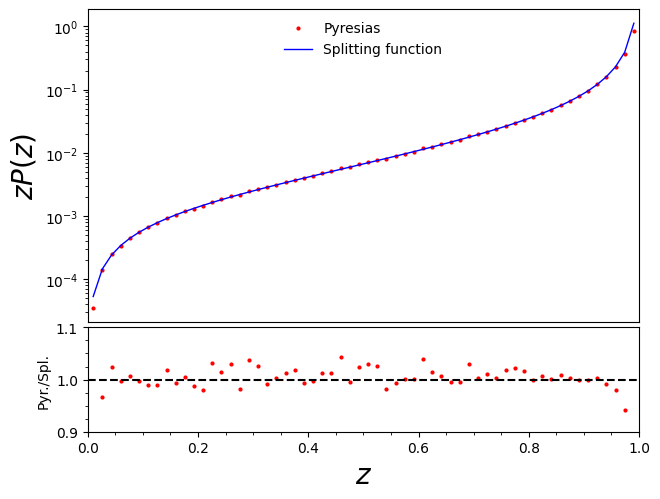

In [58]:
###########################
print('---')
print('plotting z of emissions')
# plot settings ########
plot_type = 'momentumfrac'
# plot:
# plot settings
ylab = '$zP(z)$'
xlab = '$z$'
ylog = True
xlog = False
nbins=60
# construct the axes for the plot
fig = plt.figure(constrained_layout=True)
fig.get_layout_engine().set(w_pad=0 / 72, h_pad=0 / 72, hspace=0,
                            wspace=0)
gs = gridspec.GridSpec(4, 4,figure=fig,wspace=0, hspace=0)
ax = fig.add_subplot(gs[:3, :])
ax2 = fig.add_subplot(gs[3, :])
gs.update(wspace=0,hspace=0)

ax.grid(False)
ax2.xaxis.set_minor_locator(MultipleLocator(0.05))
ax2.yaxis.set_minor_locator(MultipleLocator(0.025))

tarray = []
for i in range(len(AllEmissions)):
    tarray.append(np.array(AllEmissions[i][1]))
gs.update(wspace=0.0, hspace=0.0)

# get the histogram bins:
bins, edges = np.histogram(tarray, bins=nbins, density=True)
left,right = edges[:-1],edges[1:]
X = np.array([0.5*left+0.5*right]).T.flatten()
Y = np.array([bins]).T.flatten() * X
# normalise:
xnorm_min=0.0
xnorm_max=1.0

Y = Y/np.linalg.norm(Y[(X>xnorm_min) & (X<xnorm_max)])
Ysum = Y[(X>xnorm_min) & (X<xnorm_max)].sum()
gs.update(wspace=0.0, hspace=0.0)

# plot:
ax.plot(X,Y, label='Pyresias', color='red', lw=0, marker='o', ms=2)

# compare to the input splitting function
# this comparison is only correct if alphaS is fixed
# this is because the scale of alphaS is also a function of z 
Yspl = Pqq(X) * (X[1] - X[0]) * X

# get the integral numerically, but not in the whole range
# since the splitting function diverges as z->1 and this cannot be captured numerically:
zp = X[(X<xnorm_max)][-1]
zm = X[(X>xnorm_min)][0]
YsplI = quad(Pqq, zm, zp)
Yspl = Yspl/YsplI[0]*Ysum
ax.plot(X,Yspl, color='blue', lw=1, label='Splitting function')

# ratio:
ax2.plot(X,Y/Yspl, color='red', lw=0, label='Splitting function', marker='o', ms=2)
ax2.hlines(y=1, xmin=0, xmax=1, color='black', ls='--')

# set the ticks, labels and limits etc.
ax.set_ylabel(ylab, fontsize=20)
ax2.set_xlabel(xlab, fontsize=20)
ax2.set_ylabel('Pyr./Spl.')
ax2.set_ylim(0.9,1.1)
ax2.set_xlim(0.0,1.0)
ax.set_xlim(0.0,1.0)
# choose x and y log scales
if ylog:
    ax.set_yscale('log')
else:
    ax.set_yscale('linear')
if xlog:
    ax.set_xscale('log')
else:
    ax.set_xscale('linear')

# create legend and plot/font size
ax.legend()
ax.legend(loc="upper center", numpoints=1, frameon=False, prop={'size':10})
ax.set_xticklabels('')
ax.set_xticks([])
infile = plot_type + '.dat'
plt.savefig('plots/' + infile.replace('.dat','.pdf'), bbox_inches='tight')
